In [29]:
%matplotlib inline


# 梯度提升回归的预测区间¶
此示例演示如何使用分位数回归来创建预测区间。

通过将函数 f 应用于均匀采样的随机输入，为综合回归问题生成一些数据。

In [30]:
import numpy as np
from sklearn.model_selection import train_test_split


def f(x):
    """The function to predict."""
    return x * np.sin(x)


rng = np.random.RandomState(42)
#atleast_2d将输入视为至少具有两个维度的数组。uniform从一个均匀分布[low,high)中随机采样
X = np.atleast_2d(rng.uniform(0, 10.0, size=1000)).T
expected_y = f(X).ravel()  #预期目标值

In [31]:
print(X.shape)

(1000, 1)


为了使问题变得有趣，我们将目标 y 的观测值生成为由函数 f 计算的确定性项和遵循居中对数正态的随机噪声项的总和。为了使这更加有趣，我们考虑了噪声幅度取决于输入变量x（异方差噪声）的情况。

对数正态分布是非对称的和长尾的：观察大异常值是可能的，但不可能观察到小的异常值。


In [32]:
sigma = 0.5 + X.ravel() / 10
# lognormal(mean=0.0, sigma=1.0, size=None) 从具有指定平均值，标准偏差和数组形状的log-normal分布中抽取样本。请注意，均值和标准差不是分布本身的值，而是其基础正态分布的值。
# np.exp()返回e的幂次方，e是一个常数为2.71828
noise = rng.lognormal(sigma=sigma) - np.exp(sigma ** 2 / 2)  #噪音
y = expected_y + noise

拆分为训练、测试数据集:



In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## 拟合非线性分位数和最小二乘回归量¶

拟合梯度提升模型使用分位数损失进行训练，alpha=0.05，0.5，0.95。

获得的 alpha=0.05 和 alpha=0.95 的模型产生 90% 置信区间 （95% - 5% = 90%）。
使用 alpha=0.5 训练的模型会产生中位数的回归：平均而言，在预测值之上和之下应该有相同数量的目标观测值。





In [34]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss, mean_squared_error


all_models = {}
common_params = dict(
    learning_rate=0.05,  #learning_rate 浮点数，默认值为 0.1 学习率将每棵树的贡献缩小了。learning_rate和n_estimators之间有一个权衡。
    n_estimators=250,  #n_estimators int，默认值 = 100 要执行的加速阶段数。梯度提升对于过度拟合相当健壮，因此大量提升通常会导致更好的性能。
    max_depth=2,  #max_depth int，默认值 = 3 单个回归估计器的最大深度。最大深度限制树中的节点数。调整此参数以获得最佳性能;最佳值取决于输入变量的交互作用。
    min_samples_leaf=9,  #min_samples_leaf 整数或浮点数，默认值为 1 叶节点上所需的最小样本数。任何深度的分割点只有在每个左右分支中至少留下训练样本时，才会考虑该分割点。这可能会产生平滑模型的效果，尤其是在回归中。
    min_samples_split=9,  #min_samples_split int 或 float，默认值为 2 拆分内部节点所需的最小样本数：如果为 int，则将其视为最小数。min_samples_split 如果为浮点数，则为分数，是每次拆分的最小样本数。min_samples_split ceil(min_samples_split * n_samples)
)
for alpha in [0.05, 0.5, 0.95]:
    gbr = GradientBoostingRegressor(loss="quantile",  #default='squared_error' 损失功能有待优化。"squared_error"是指回归的平方误差。"absolute_error"是指回归的绝对误差，是一个稳健的损失函数。"huber"是两者的结合。"quantile"允许分位数回归（用于指定分位数）
                                    alpha=alpha,  #alpha 浮点数，默认值为 0.9 huber损失函数和分位数损失函数的alpha分位数。只有在或.loss = ' huber ' .loss = ' .quantile '
                                    **common_params)
    all_models["q %1.2f" % alpha] = gbr.fit(X_train, y_train)

为了进行比较，我们还拟合了使用通常（均值）平方误差（MSE）训练的基线模型。


In [35]:
gbr_ls = GradientBoostingRegressor(loss="squared_error",  #loss="squared_error" 回归的平方误差
                                   **common_params)
all_models["mse"] = gbr_ls.fit(X_train, y_train)

创建跨越 [0， 10] 范围的输入值的均匀分布的评估集。


In [36]:
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T

绘制真实条件均值函数 f、条件均值（损失等于平方误差）、
条件中位数和条件 90% 区间（从第 5 个条件百分位数到第 95 个条件百分位数）的预测值。


C:\Users\yalin\AppData\Local\Temp/ipykernel_25584/2106865079.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(xx, y_med, "r-", label="Predicted median", color="orange")


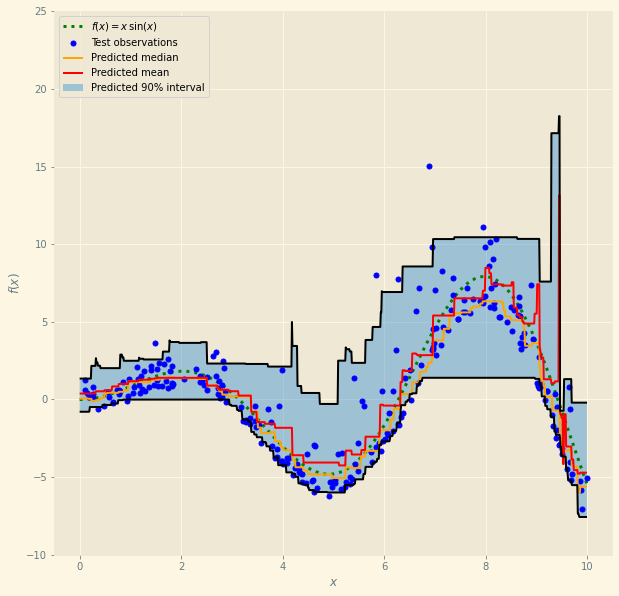

In [47]:
import matplotlib.pyplot as plt
plt.style.use(plt.style.available[0])

y_pred = all_models["mse"].predict(xx)  #均值的（损失等于平方误差）
y_lower = all_models["q 0.05"].predict(xx)
y_upper = all_models["q 0.95"].predict(xx)
y_med = all_models["q 0.50"].predict(xx)

fig = plt.figure(figsize=(10, 10))
plt.plot(xx, f(xx), "g:", linewidth=3, label=r"$f(x) = x\,\sin(x)$")
plt.plot(X_test, y_test, "b.", markersize=10, label="Test observations")
plt.plot(xx, y_med, "r-", label="Predicted median", color="orange")
plt.plot(xx, y_pred, "r-", label="Predicted mean")
plt.plot(xx, y_upper, "k-")
plt.plot(xx, y_lower, "k-")
plt.fill_between(
    xx.ravel(), y_lower, y_upper, alpha=0.4, label="Predicted 90% interval"
)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.ylim(-10, 25)
plt.legend(loc="upper left")
plt.show()

将预测中位数与预测均值进行比较，我们注意到中位数平均低于均值，因为噪声偏向于高值（大异常值）。
中位数估计值似乎也更平滑，因为它对异常值具有天然的鲁棒性。

还要观察到，不幸的是，梯度提升树的归纳偏差阻止了我们的0.05分位数完全捕获信号的正弦形状，
特别是在x=8左右。调整超参数可以减少这种影响，如本笔记本的最后一部分所示。


## 错误指标分析
使用训练数据集和指标测量模型。mean_squared_errormean_pinball_loss


In [38]:
import pandas as pd


def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]


results = []
for name, gbr in sorted(all_models.items()):
    metrics = {"model": name}
    y_pred = gbr.predict(X_train)
    for alpha in [0.05, 0.5, 0.95]:
        metrics["pbl=%1.2f" % alpha] = mean_pinball_loss(  #分位数回归的弹球损失。
            y_train,  #y_true: array-like of shape (n_samples,) or (n_samples, n_outputs) 的类似数组基本实况（正确）目标值。
            y_pred,  #y_pred array-like of shape (n_samples,) or (n_samples, n_outputs)
            alpha=alpha)  #alpha: double, 弹球损失的斜率，默认值=0.5, 当 ，则由第 95 百分位的估计器最小化时，此损失等价于平均绝对误差。alpha=0.5 alpha=0.95
    metrics["MSE"] = mean_squared_error(  #均方误差回归损失。
        y_train,  #y_true:形状 （n_samples） 或 （n_samples，n_outputs） 的类似数组基本实况（正确）目标值。
        y_pred)  #估计目标值。
    results.append(metrics)

pd.DataFrame(results).set_index("model").style.apply(highlight_min)

,pbl=0.05,pbl=0.50,pbl=0.95,MSE
model,,,,
mse,0.706216,0.706216,0.706216,7.374961
q 0.05,0.112202,1.106613,2.101025,16.420012
q 0.50,0.297918,0.618546,0.939173,9.808202
q 0.95,3.829411,2.103431,0.377451,28.106030


一列显示由同一指标评估的所有模型。当使用相同的指标训练和测量模型时，应获取列上的最小数量。
如果训练收敛，则在训练集上应始终如此。

请注意，由于目标分布是不对称的，因此预期的条件均值和条件中位数明显不同，
因此不能使用平方误差模型来获得条件中位数的良好估计值，也无法获得相反的估计值。

如果目标分布是对称的并且没有异常值（例如，使用高斯噪声），则中值估计器和最小二乘估计器将产生类似的预测。

然后，我们在测试集上执行相同的操作。


In [39]:
results = []
for name, gbr in sorted(all_models.items()):
    metrics = {"model": name}
    y_pred = gbr.predict(X_test)
    for alpha in [0.05, 0.5, 0.95]:
        metrics["pbl=%1.2f" % alpha] = mean_pinball_loss(y_test, y_pred, alpha=alpha)
    metrics["MSE"] = mean_squared_error(y_test, y_pred)
    results.append(metrics)

pd.DataFrame(results).set_index("model").style.apply(highlight_min)

,pbl=0.05,pbl=0.50,pbl=0.95,MSE
model,,,,
mse,0.933180,0.772983,0.612786,7.011503
q 0.05,0.133308,1.078019,2.022731,12.624741
q 0.50,0.408773,0.607041,0.805309,5.842858
q 0.95,4.284478,2.319882,0.355287,34.343416


误差较高，这意味着模型略微过度拟合数据。
它仍然表明，当通过最小化相同的指标来训练模型时，可以获得最佳测试指标。

请注意，就测试集上的 MSE 而言，条件中位数估计器与平方误差估计器具有竞争力：
这可以通过以下事实来解释：平方误差估计器对可能导致严重过度拟合的大异常值非常敏感。
这可以在上一个情节的右侧看到。条件中位数估计器是有偏差的（对这种不对称噪声的低估），
但对异常值也是自然鲁棒的，并且过拟合较少。

## 置信区间的校准
我们还可以评估两个极端分位数估计器在产生良好校准的假设90%置信区间方面的能力。

为此，我们可以计算落在预测之间的观测值的分数：


In [40]:
# 覆盖分数
def coverage_fraction(y, y_low, y_high):
    #np.logical_and 逐元素计算逻辑与运算
    return np.mean(np.logical_and(y >= y_low, y <= y_high))


coverage_fraction(
    y_train,
    all_models["q 0.05"].predict(X_train),
    all_models["q 0.95"].predict(X_train),
)

0.9026666666666666

在训练集上，校准非常接近 90% 置信区间的预期覆盖率值。



In [41]:
coverage_fraction(
    y_test, all_models["q 0.05"].predict(X_test), all_models["q 0.95"].predict(X_test)
)

0.84

在检验集上，估计置信区间略微过窄。
但请注意，我们需要将这些指标包装在交叉验证循环中，以评估它们在数据重采样下的可变性。

## 调整分位数回归量的超参数
在上图中，我们观察到第5百分位回归器似乎不合适，无法适应信号的正弦形状。

模型的超参数近似于针对中位数回归量进行了手动调谐，没有理由认为相同的超参数适用于第 5 百分位回归量。

为了证实这一假设，我们通过对alpha=0.05的弹球损失进行交叉验证来选择最佳模型参数，从而调整第5百分位的新回归量的超参数：

In [49]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from pprint import pprint


param_grid = dict(
    learning_rate=[0.01, 0.05, 0.1],
    n_estimators=[100, 150, 200, 250, 300],
    max_depth=[2, 5, 10, 15, 20],
    min_samples_leaf=[1, 5, 10, 20, 30, 50],
    min_samples_split=[2, 5, 10, 20, 30, 50],
)
alpha = 0.05
neg_mean_pinball_loss_05p_scorer = make_scorer(  #根据性能指标或损失函数创建评分器
    mean_pinball_loss,
    alpha=alpha,
    greater_is_better=False,  # maximize the negative loss
)
gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, random_state=0)
search_05p = RandomizedSearchCV(  #对超参数进行随机搜索
    gbr,  #估计器对象
    param_grid,  #以参数名称 （） 为键和分布或要尝试的参数列表的字典
    n_iter=10,  # increase this if computational budget allows
    scoring=neg_mean_pinball_loss_05p_scorer,  #用于评估测试集上交叉验证模型性能的策略
    n_jobs=4,  #要并行运行的作业数
    random_state=0,
).fit(X_train, y_train)
pprint(search_05p.best_params_)

{'learning_rate': 0.1,
 'max_depth': 20,
 'min_samples_leaf': 30,
 'min_samples_split': 5,
 'n_estimators': 200}


我们观察到，搜索过程确定需要更深的树才能很好地拟合第 5 百分位回归量。
更深的树木更具表现力，不太可能不合适。

现在，让我们调整第 95 百分位回归量的超参数。我们需要重新定义用于选择最佳模型的指标，
同时调整内部梯度提升估计器本身的 alpha 参数：scoring


In [50]:
from sklearn.base import clone

alpha = 0.95
neg_mean_pinball_loss_95p_scorer = make_scorer(  #根据性能指标或损失函数创建评分器
    mean_pinball_loss,
    alpha=alpha,
    greater_is_better=False,  # maximize the negative loss 使负损失最大化
)
search_95p = clone(search_05p).set_params(
    estimator__alpha=alpha,
    scoring=neg_mean_pinball_loss_95p_scorer,
)
search_95p.fit(X_train, y_train)
pprint(search_95p.best_params_)

{'learning_rate': 0.1,
 'max_depth': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 50,
 'n_estimators': 250}


这一次，选择较浅的树，并导致更恒定的分段，因此对第95百分位的估计更可靠。
这是有益的，因为它避免了对数正态加性噪声的大异常值的过度拟合。

我们可以通过显示由这两个调谐的分位数回归量的预测组成的预测的90%置信区间来确认这种直觉：
第95百分位上限的预测比第5百分位数的预测要粗糙得多：


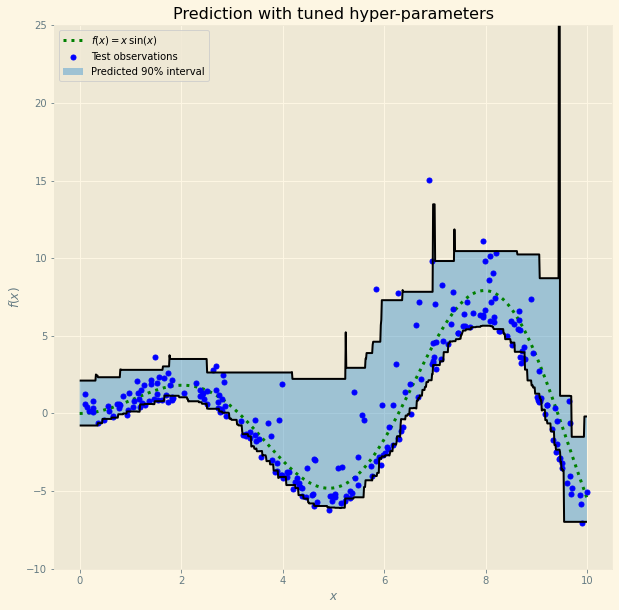

In [51]:
y_lower = search_05p.predict(xx)
y_upper = search_95p.predict(xx)

fig = plt.figure(figsize=(10, 10))
plt.plot(xx, f(xx), "g:", linewidth=3, label=r"$f(x) = x\,\sin(x)$")
plt.plot(X_test, y_test, "b.", markersize=10, label="Test observations")
plt.plot(xx, y_upper, "k-")
plt.plot(xx, y_lower, "k-")
plt.fill_between(
    xx.ravel(), y_lower, y_upper, alpha=0.4, label="Predicted 90% interval"
)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.ylim(-10, 25)
plt.legend(loc="upper left")
plt.title("Prediction with tuned hyper-parameters")
plt.show()

该图在质量上看起来比未调整的模型更好，特别是对于下分位数的形状。

我们现在定量评估一对估计器的联合校准：


In [52]:
coverage_fraction(y_train, search_05p.predict(X_train), search_95p.predict(X_train))

0.8986666666666666

In [53]:
coverage_fraction(y_test, search_05p.predict(X_test), search_95p.predict(X_test))

0.768

可悲的是，在测试集上，调谐对的校准并不好：估计置信区间的宽度仍然太窄。

同样，我们需要将这项研究包装在一个交叉验证循环中，以更好地评估这些估计的可变性。